In [1]:
install.packages("tseries")
install.packages("forecast")
install.packages("scales")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("scales"):
“installation of package ‘scales’ had non-zero exit status”


In [2]:
library("ggplot2")
library("tseries")
library("forecast")
library("base")
library("scales")

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



# Introducción

En el presente capítulo se realizará el análisis para la serie de tiempo cantidad de viajes realizados en la Ciudad de México utilizando las bicicletas del programa de gobierno *EcoBici*, en base a la metodología de los modelos $ARIMA$.



Los datos se encuentran presentes en cada una de las bases de datos, las cuales pueden obtenerse descargándolas desde la página oficial del programa [Ecobici](https://www.ecobici.cdmx.gob.mx/es/informacion-del-servicio/open-data). Los datos son mensuales y se cuenta con información desde febrero de $2010$ hasta mayo $2020$, por lo que se tiene un total de $124$ observaciones, las cuales representan la cantidad de viajes realizados en el respectivo mes y año.

# Objetivo

Pronosticar la cantidad de viajes realizados desde enero hasta mayo de $2020$ analizando la diferencia entre lo pronosticado y los datos reales dada la cuarentena originada por la pandemia de $COVID-19$.

# Métodología y análisis

### Lectura y preparación de datos

In [3]:
data <- read.csv("EcoBici.csv", stringsAsFactors = FALSE) ### No se desea que el anio sea un factor, lo queremos como string

In [4]:
head(data)

,Anio,Viajes
,<chr>,<int>
1,2010-02,1057
2,2010-03,21024
3,2010-04,44984
4,2010-05,59814
5,2010-06,64704
6,2010-07,58767


In [5]:
tail(data)

,Anio,Viajes
,<chr>,<int>
119,2019-12,584185
120,2010-01,676908
121,2010-02,686327
122,2010-03,529077
123,2010-04,159780
124,2010-05,153147


Los últimos $5$ años deberían indicar $2020$ en la sección del año, a pesar de que indique $2010$.

In [6]:
data$Anio[120:124] <- gsub("2010", "2020", data$Anio[120:124])

Se prefiere trabajar con letras minúsculas, por lo que se cambiará la primera letra del nombre de cada columna a minúscula, además la primer columna `anio` no hace referencia al año únicamente, sino también al mes correspondiente, por lo que hará el cambio del nombre a `fecha`.

In [7]:
colnames(data) <- c("fecha", "viajes")

### Estructura de datos

In [8]:
summary(data)

    fecha               viajes      
 Length:124         Min.   :  1057  
 Class :character   1st Qu.:218704  
 Mode  :character   Median :665850  
                    Mean   :540405  
                    3rd Qu.:745155  
                    Max.   :878358  

In [9]:
str(data)

'data.frame':	124 obs. of  2 variables:
 $ fecha : chr  "2010-02" "2010-03" "2010-04" "2010-05" ...
 $ viajes: int  1057 21024 44984 59814 64704 58767 82329 100164 132294 134082 ...


Nótese que la variable `fecha` aparece como  `chr`, cuando en realidad debería ser un objeto `date` de `R`, a continuación se realizará el cambio correspondiente, para ello se supondrá que todos los meses tienen $28$ días, pues la función `as.Date`, presenta dificultades al tratar de identificar un mes que en tiene $28$ días (febrero) al momento de agregarle $30$ días o más.

In [10]:
data$fecha <- as.Date(paste0(data$fecha,"-28"))

In [11]:
data[which.min(data$viajes),]

,fecha,viajes
,<date>,<int>
1,2010-02-28,1057


In [12]:
data[which.max(data$viajes),]

,fecha,viajes
,<date>,<int>
86,2017-03-28,878358


* La cantidad menor de viajes fue de $1,057$ lo cual se obtuvo al inicio del programa, esto es, en febrero de $2010$.
* La cantidad mayor de viajes fue de $878,358$ obtenida el $2012-03$, esto es, en marzo de $2017$.

### Visualización de la serie de tiempo

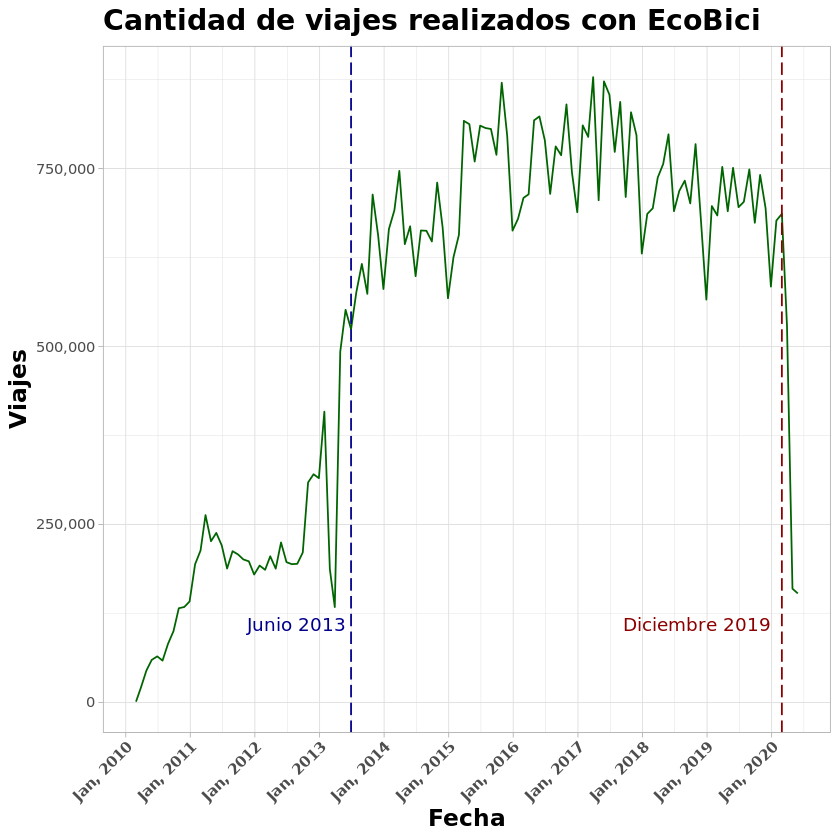

In [13]:
ggplot(data, aes(x = fecha, y = viajes)) + 
    theme_light() +
    geom_line(color = "darkgreen") + 
    scale_x_date(breaks='1 years', date_labels = "%b, %Y") + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"), 
          plot.title = element_text(size = 17, face = "bold"), 
          axis.title = element_text(size=14, face="bold")) + 
    scale_y_continuous(labels = comma) +
    geom_vline(xintercept = as.numeric(data$fecha[41]),
                linetype = 5, colour="darkblue") + 
    geom_vline(xintercept = as.numeric(data$fecha[121]),
                linetype = 5, colour="darkred") + 
    geom_text(data = data.frame(fecha = as.Date("2013-06-28"), 
                                box_cox = 110000), 
              aes(fecha, box_cox), label = "Junio 2013", hjust = 1.05, color = "darkblue") + 
    geom_text(data = data.frame(fecha = as.Date("2019-12-28"), 
                                box_cox = 110000), 
              aes(fecha, box_cox), label = "Diciembre 2019", hjust = 1, color = "darkred") + 
    xlab("Fecha") + 
    ylab("Viajes") +
    ggtitle("Cantidad de viajes realizados con EcoBici")

Al parecer la serie de tiempo comienza a estabilizarse a partir de junio de $2013$, esta fecha está marcada con una franja azul en el gráfico anterior, posteriormente tiene un decremento considerable en abril año $2020$, un mes después de que se decretó la pandemia originada por el $COVID-19$. 

Se tomarán todas las observaciones a excepción de aquellas del $2020$ y aquellas previas a junio $2013$, para obtener el modelo así como su respectiva estimación de parámetro y pruebas estadísticas necesarias. 

In [14]:
data_mod <- data[1:119,]

In [15]:
data_mod <- data_mod[-c(1:43),]

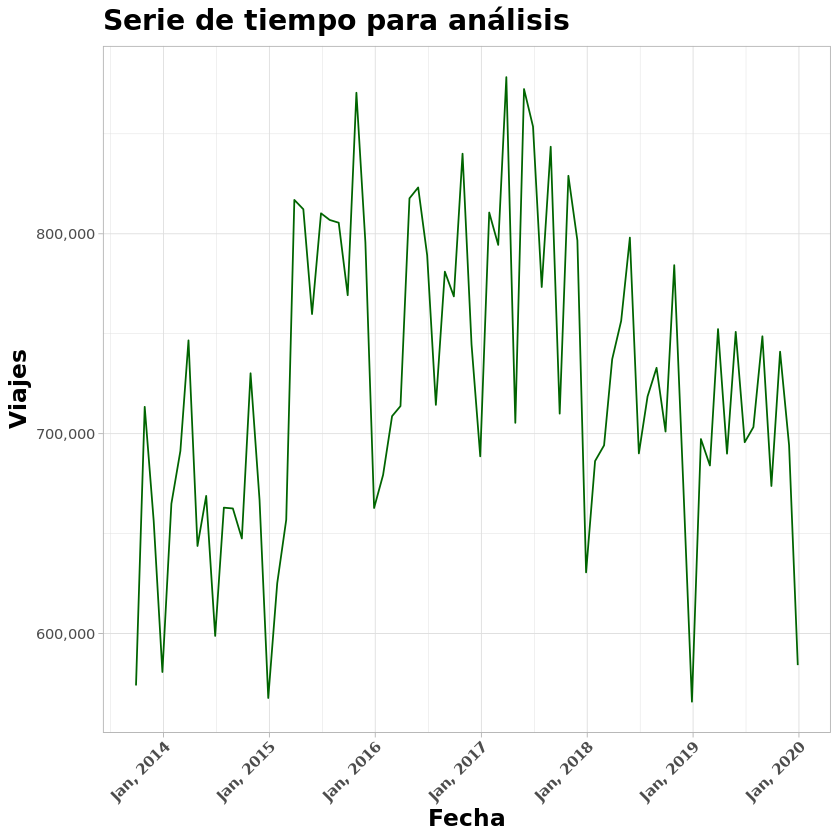

In [16]:
ggplot(data_mod, aes(x = fecha, y = viajes)) + 
    theme_light() +
    geom_line(color = "darkgreen") + 
    scale_x_date(breaks='1 years', date_labels = "%b, %Y") + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"), 
          plot.title = element_text(size = 17, face = "bold"), 
          axis.title = element_text(size=14, face="bold")) + 
    scale_y_continuous(labels = comma) +
    xlab("Fecha") + 
    ylab("Viajes") +
    ggtitle("Serie de tiempo para análisis")

### Grado de diferenciación $(d)$ y parámetro $\lambda$ para la estabilización de la varianza

Se utilizará la transformación $Box-Cox$ para la estabilización de la varianza.

In [17]:
lamb <- BoxCox.lambda(data_mod$viajes)
lamb

[1] 1.005101

Notemos que la transformación sugerida por la metodología de $Box-Cox$ es muy cercana a $1$, valor que equivale a dejar los datos tal y como se encuentran, es decir sin ninguna transformación. Se tomará el valor $\lambda = 1$, debido a la simplicidad.

In [18]:
lamb <- 1

In [19]:
tran_box <- function(xt,lamb){
    ### Calcula la transformación de Box - Cox
    # Input xt (vector): serie de tiempo a realizar transformación
    # Input (lamb): parámetro estabilizador de la varianza
    # Output (xt_box): serie de tiempo operada con la transformación
    
    if (lamb == 0) {
    xt_box <- log(xt)
    } else {
        xt_box <- (xt^lamb - 1)/lamb
    }
    return(xt_box)  
}

In [20]:
data_mod$box_cox <- tran_box(data_mod$viajes, lamb)

Visualizemos la serie de tiempo tras el proceso de estabilización de la varianza

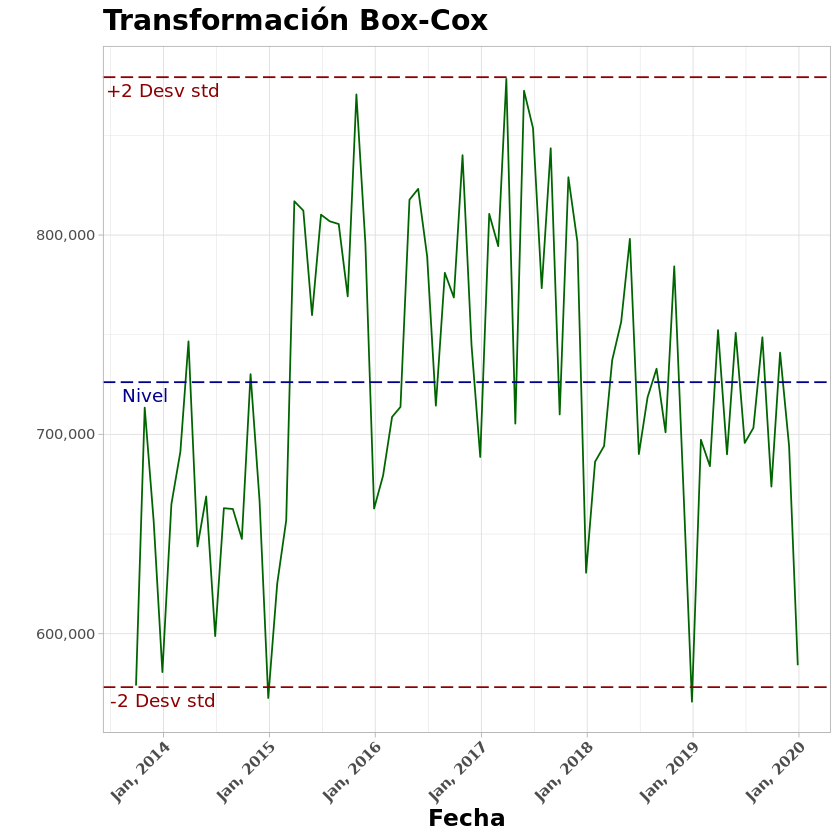

In [21]:
events <- data.frame(level = c((mean(data_mod$box_cox) + 2*sqrt(var(data_mod$box_cox))),
                              (mean(data_mod$box_cox) - 2*sqrt(var(data_mod$box_cox))),
                              mean(data_mod$box_cox)),
                     text = c(c("+2 Desv std", "Nivel", "-2 Desv std")))

ggplot(data_mod, aes(x = fecha, y = box_cox)) + 
    theme_light() +
    geom_line(color = "darkgreen") + 
    scale_x_date(breaks='1 years', date_labels = "%b, %Y") + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"), 
          plot.title = element_text(size = 17, face = "bold"), 
          axis.title = element_text(size=14, face="bold")) + 
    scale_y_continuous(labels = comma) +
    geom_hline(yintercept = (mean(data_mod$box_cox) + 2*sqrt(var(data_mod$box_cox))),
                linetype = 5, colour="darkred") + 
    geom_hline(yintercept = (mean(data_mod$box_cox) - 2*sqrt(var(data_mod$box_cox))),
                linetype = 5, colour="darkred") + 
    geom_hline(yintercept = mean(data_mod$box_cox),
                linetype = 5, colour="darkblue") + 
    xlab("Fecha") + 
    ylab("") +
    geom_text(data = data.frame(fecha = as.Date("2013-10-28"), 
                                box_cox = (mean(data_mod$box_cox) + 2*sqrt(var(data_mod$box_cox)))), 
              aes(fecha, box_cox), label = "      +2 Desv std", vjust = 1.5, color = "darkred") + 
    geom_text(data = data.frame(fecha = as.Date("2013-10-28"), 
                                box_cox = (mean(data_mod$box_cox) - 2*sqrt(var(data_mod$box_cox)))), 
              aes(fecha, box_cox), label = "      -2 Desv std", vjust = 1.5, color = "darkred") + 
    geom_text(data = data.frame(fecha = as.Date("2013-10-28"), 
                                box_cox = mean(data_mod$box_cox)), 
              aes(fecha, box_cox), label = "Nivel", vjust = 1.5, color = "darkblue") + 
    ggtitle("Transformación Box-Cox")

Nótese que parece ser que la serie de tiempo ya parece estar estabilizada, pues se encuentra dentro de las franjas rojas, las cuales marcan $2$ desviaciones estándares de los datos. Nótese que los datos se encuentran alrededor del nivel (media o promedio) marcado con la franja roja, mas hay un pequeño desajuste en los mismos para corregir esto se aplicará el una sola vez el operador diferencia $(\nabla)$.

Visualizemos la serie de tiempo con una diferencia $(d = 1)$.

In [22]:
st_d1 <- diff(data_mod$box_cox, 1)
data_d1 <- data.frame(fecha = data_mod$fecha[-1], st_d1 = st_d1)

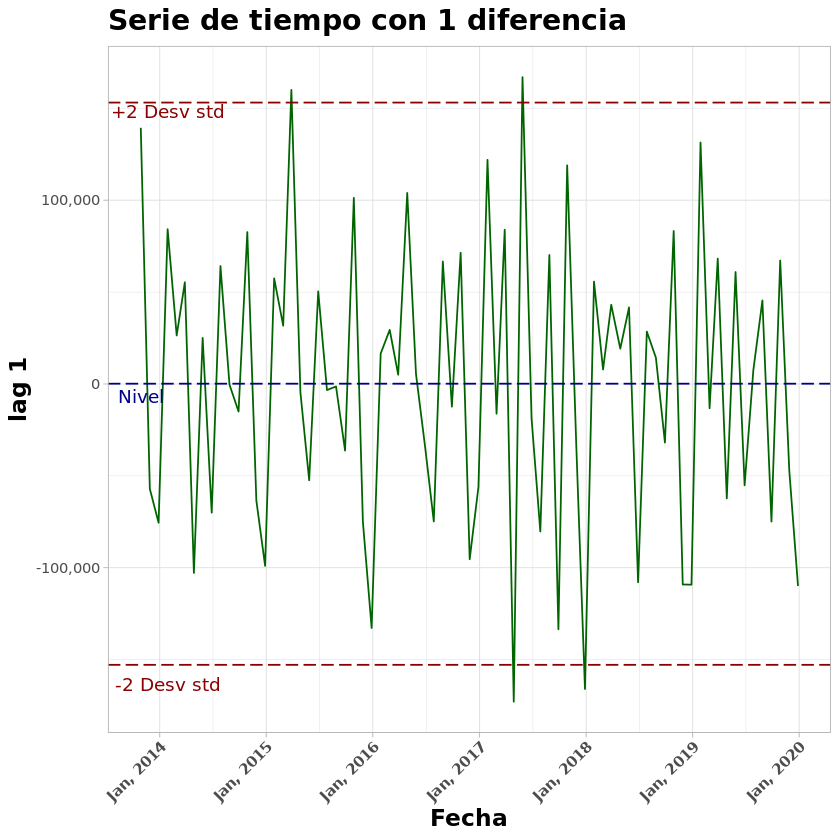

In [24]:
ggplot(data_d1, aes(x = fecha, y = st_d1)) + 
    theme_light() +
    geom_line(color = "darkgreen") + 
    scale_x_date(breaks='1 years', date_labels = "%b, %Y") + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"), 
          plot.title = element_text(size = 17, face = "bold"), 
          axis.title = element_text(size=14, face="bold")) + 
    scale_y_continuous(labels = comma) +
    geom_hline(yintercept = (mean(data_d1$st_d1) + 2*sqrt(var(data_mod$box_cox))),
                linetype = 5, colour="darkred") + 
    geom_hline(yintercept = (mean(data_d1$st_d1) - 2*sqrt(var(data_mod$box_cox))),
                linetype = 5, colour="darkred") + 
    geom_hline(yintercept = (mean(data_d1$st_d1)),
                linetype = 5, colour="darkblue") + 
    xlab("Fecha") + 
    ylab("lag 1") +
    geom_text(data = data.frame(fecha = as.Date("2013-10-28"), 
                                box_cox = (mean(data_d1$st_d1) + 2*sqrt(var(data_d1$st_d1)))), 
              aes(fecha, box_cox), label = "         +2 Desv std", vjust = 1.7, color = "darkred") + 
    geom_text(data = data.frame(fecha = as.Date("2013-10-28"), 
                                box_cox = (mean(data_d1$st_d1) - 2*sqrt(var(data_d1$st_d1)))), 
              aes(fecha, box_cox), label = "         -2 Desv std", vjust = 1.5, color = "darkred") + 
    geom_text(data = data.frame(fecha = as.Date("2013-10-28"), 
                                box_cox = mean(data_d1$st_d1)), 
              aes(fecha, box_cox), label = "Nivel", vjust = 1.5, color = "darkblue") + 
    ggtitle("Serie de tiempo con 1 diferencia")

Nótese que parece ser que el error ha sido corregido, para verificar esto se realizará la prueba de **Dickey-Fuller** con el objetivo de tener evidencia estadística de que el grado de diferenciación $d = 1$ es aceptable (nivel de significancia $\alpha = 0.05$).

In [25]:
adf.test(data_d1$st_d1, alternative = "stationary", k = 1)

Warning message in adf.test(data_d1$st_d1, alternative = "stationary", k = 1):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  data_d1$st_d1
Dickey-Fuller = -8.8647, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary


Se rechaza la hipótesis nula, esta es, la serie de tiempo no es estacionaria y se prosigue con el análisis.

In [26]:
adf.test(data_mod$box_cox, alternative = "stationary", k = 1)


	Augmented Dickey-Fuller Test

data:  data_mod$box_cox
Dickey-Fuller = -3.4596, Lag order = 1, p-value = 0.05249
alternative hypothesis: stationary


Al realizar la misma prueba estadística a la serie de tiempo sin diferenciar se llega a la conclusión de que la misma no es estacionaria, con lo cual concluímos que es necesario de una diferencia.

### Función de autocorrelación y función de autocorrelación

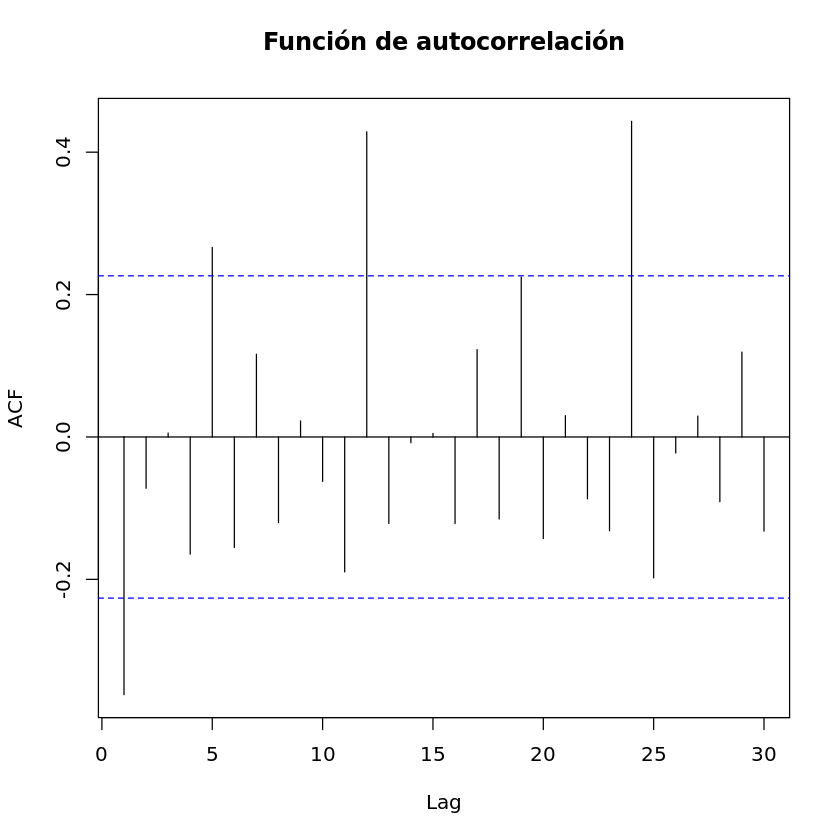

In [27]:
Acf(data_d1$st_d1, main='Función de autocorrelación', lag.max = 30)

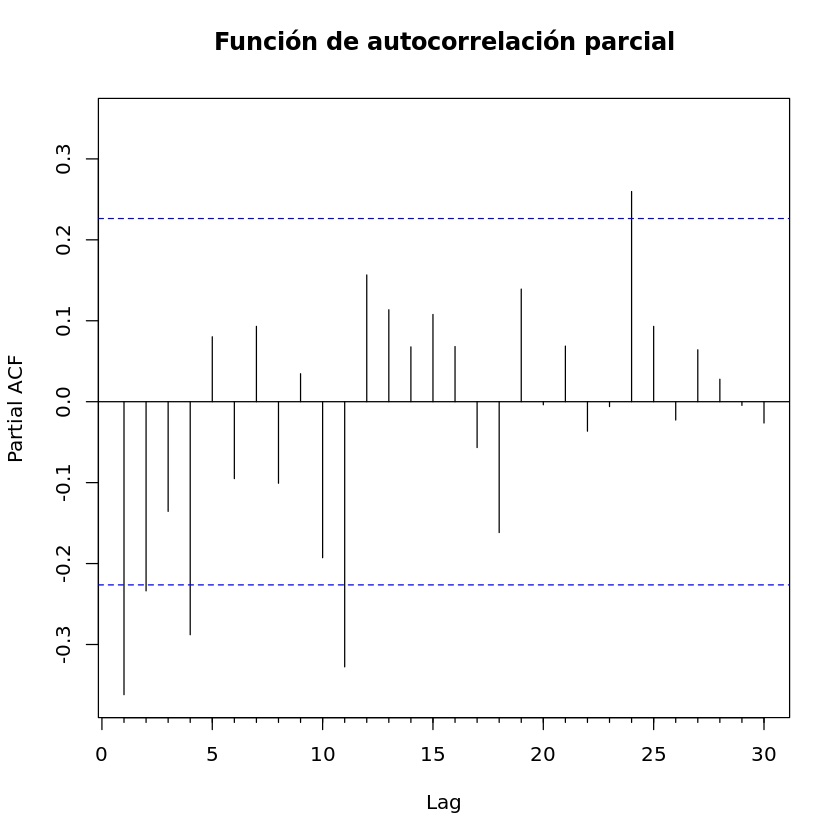

In [28]:
Pacf(data_d1$st_d1, main='Función de autocorrelación parcial', lag.max = 30)

La función de autocorrelación y la función de autocorrelaciónparcial sugieren tratar elegir un un modelo con parte estacional anual y con polinomios autorregresivos $(AR)$ y de promedios móviles $(MA)$ ambos de primer grado.

### Modelos

El modelo a estimar es el siguiente:


* `mod_1` = $ARIMA(p = 1, d = 1, q = 0)x(P = 1, D = 1, Q = 0)_{E=12}$




In [29]:
mod_1 <- Arima(y = data_d1$st_d1,
               order = c(1, 0, 0), 
               seasonal = list(order = c(1, 1, 0), period = 12), lambda = lamb, biasadj = TRUE)

Los intervalos de confianza para los parámetros (coeficientes de los polinomios) estimados para `mod_1` son:

In [30]:
confint(mod_1)

,2.5 %,97.5 %
ar1,-0.6117450,-0.1578070
sar1,-0.7647864,-0.3972605


Nótese que los intervalos de confianza para los parámetros estimados no contienen el $0$ o son cercanos a este valor, esto es una **propiedad importante y deseable** para el análisis, pues en caso de que lo contuviera alguno de ellos, implica directamente que existe evidencia estadística para eliminar aglún polinomio o bien replantear el modelo.

### Pronósticos

Para la evaluación del modelo se hará el pronóstico de enero hasta mayo del $2020$, para ello se obtuvo el modelo con todas las observaciones excepto aquellas que hagan mención al $2020$, tal y como ya se había mencionado anteriormente.

In [31]:
fcast <- forecast(mod_1, h = 5)
fcast

   Point Forecast       Lo 80     Hi 80      Lo 95    Hi 95
76       74999.52   -591.5671 150590.60  -40607.07 190606.1
77        3801.50 -77192.2412  84795.24 -120067.74 127670.7
78       51776.89 -29986.3907 133540.18  -73269.26 176823.0
79      -14234.01 -96110.6101  67642.60 -139453.47 110985.5
80       49441.61 -32451.7589 131334.98  -75803.49 174686.7

Obsérvese que los intervalos de confianza al nivel $95\%$ toman valores negativos, lo cual podría pensarse que esto no tiene sentido en la vida real, pues no existen cantidades, en este caso de viajes, negativas, sin embargo, no debe olvidarse que se está trabajando con la serie de tiempo transformada, 
pues se añadió un grado de diferenciación. A continuación se obtendrá el pronóstico para la serie de tiempo original.

In [32]:
pronostico <- c()
valor_real <- data$viajes[119:124]
for(i in 1:5){
    pronostico[i] <- fcast$mean[i] + valor_real[i]
}

In [33]:
valor_real <- data$viajes[120:124]
upper <- fcast$upper %>% 
    .[,2]
lower <- fcast$lower %>% 
    .[,2]
dif_up <- c()
dif_lo <- c()
new_up <- c()
new_lo <- c()

for(i in 1:5){
    dif_up[i] <- upper[i] - fcast$mean[i]
    dif_lo[i] <- fcast$mean[i] - lower[i] 
    new_up[i] <- pronostico[i] + dif_up[i]
    new_lo[i] <- pronostico[i] - dif_lo[i]
}

In [34]:
last_date <- data$fecha %>% 
                tail(5)
forecast_ts <- data.frame(fecha = rep(last_date, 2),
                          value = c(valor_real, pronostico),
                          Up_CI = c(valor_real, new_up),
                          Lo_CI = c(valor_real, new_lo),
                          Valor = c(rep("Original", 5), rep("Pronostico", 5)))

Los pronósticos obtenidos para la serie de tiempo original con sus respectivos intervalos de confianza al $95\%$ son:

In [35]:
forecast_ts[6:10,-5]

,fecha,value,Up_CI,Lo_CI
,<date>,<dbl>,<dbl>,<dbl>
6,2020-01-28,659184.5,774791.1,543577.93
7,2020-02-28,680709.5,804578.7,556840.26
8,2020-03-28,738103.9,863150.0,613057.74
9,2020-04-28,514843.0,640062.5,389623.53
10,2020-05-28,209221.6,334466.7,83976.51


Nótese que el intervalo de confianza inferior (columna `Lo_CI`) es positivo para todos los pronósticos, lo cual sí tiene sentido para el análisis.

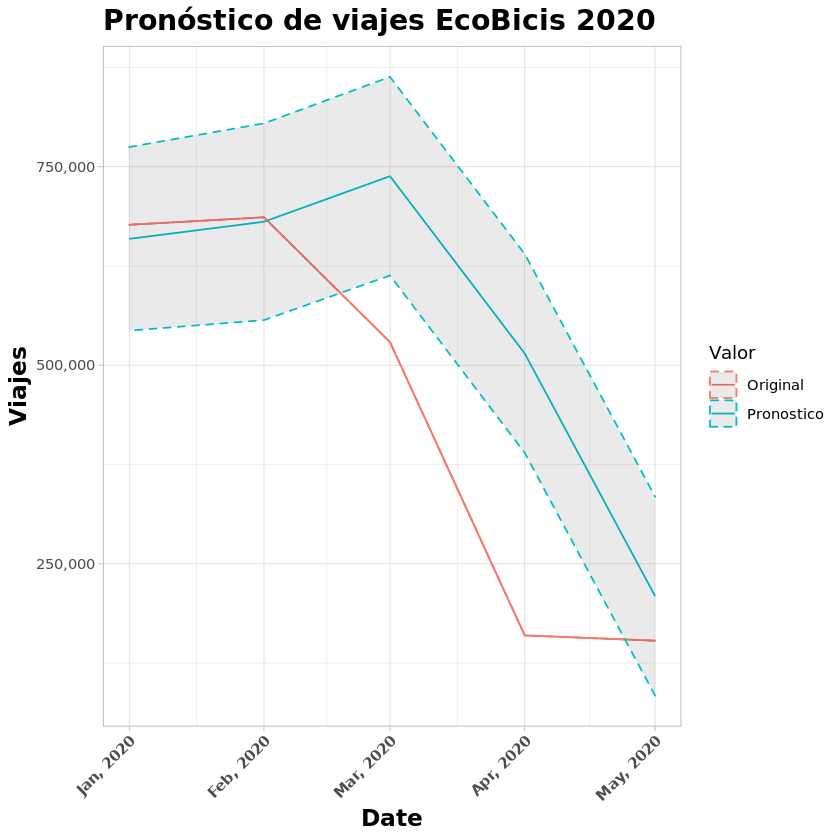

In [36]:
ggplot(forecast_ts, aes(x = fecha, y = value, color = Valor)) + 
    theme_light() +
    scale_x_date("Date", breaks = seq(min(forecast_ts$fecha), max(forecast_ts$fecha), by = "month"), 
                 date_labels = "%b, %Y") +
    geom_line() + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"), 
          plot.title = element_text(size = 17, face = "bold"), 
          axis.title = element_text(size=14, face="bold")) + 
    scale_y_continuous(labels = comma) +
    xlab("Fecha") + 
    ylab("Viajes") +
    ggtitle("Pronóstico de viajes EcoBicis 2020") +
    geom_ribbon(aes(ymin = Lo_CI, ymax = Up_CI), linetype=2, alpha=0.1)

### Error cuadrático medio $(ECM)$ y error relativo

Por último se calculará tanto el error cuadrático medio como el error relativo para analizar los pronósticos obtenidos.

In [37]:
relative_error <- function(x, y){
    ### Calcula el error relativo
    # Input x (vector): valor real
    # Input y (vector): pronostico o aproximación
    # Output rdo (float): error relativo entre x, y; o bien regresa string de error en caso de que las dimensiones 
    #                     no sean las mismas
    
    n <- length(x)
    m <- length(y)
    if(n == m){
        rdo <- sum(abs(x-y)/x)
    }else{
        rdo <- "Las dimensiones entre los datos debe ser la misma"
    }
    return(rdo)
}

In [38]:
ecm <- function(x, y){
    ### Calcula el error cuadrático medio
    # Input x (vector): valor real
    # Input y (vector): pronostico o aproximación
    # Output rdo (float): error cuadrático medio entre x, y; o bien regresa string de error en caso de que las dimensiones 
    #                     no sean las mismas
    
    n <- length(x)
    m <- length(y)
    if(n == m){
        rdo <- sum((x-y)^2/x)
    }else{
        rdo <- "Las dimensiones entre los datos debe ser la misma"
    }
    return(rdo)
}

Error relativo entre el pronóstico y el valor real:

In [39]:
relative_error(valor_real, pronostico)

[1] 3.017794

El error cuadrático medio es:

In [40]:
ecm(valor_real, pronostico)

[1] 892644.4

### Conclusiones

* Los pronósticos en general erran demasiado, por lo que las métricas de error relativo y error cuadrático medio son demasiado altas, esto se debe a que el modelo sobreestimó la cantidad de viajes realizados en marzo y abril, las cuales fueron las fechas donde la cuarentena alcanzó sus niveles de mayor cuidado en relación a las demás fechas.
* Se muestra perfectamente que un evento catastrófico puede alterar demasiado los modelos $ARIMA$, pues no son entrenados con información relacionada a un evento similar al que ocurrió en este caso, en caso de que hubiese ocurrido uno similar, podría calibrarse el modelo contemplando dicha información.

### Referencias

* Guerrero, V. M., (2014). *Análisis estadístico y pronóstico de series de tiempo económicas*, México DF, México: Jit Press.
* [Pronósticos](https://rpubs.com/riazakhan94/arima_with_example)
* [Transformación Box-Cox](http://betaeconomia.blogspot.com/2019/11/transformaciones-de-series-temporales.html)
* [Prueba de Dickey-Fuller](https://nwfsc-timeseries.github.io/atsa-labs/sec-boxjenkins-aug-dickey-fuller.html)